# Pointcloud generation with VAE - attempt 2

This notebook tries the following approach: Encode each point with combinations of global mean over all point features (permutation invariant) and per-point transformations (permutation equivariant) into a global latent space.
Then sample per-point from this latent space and concatenate. The reconstruction loss uses the chamfer distance since we don't have a per-point association anymore for input and reconstructed points.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd

# Load dataset

In [2]:
#DATASET = "MNIST" # 28x28 images
DATASET = "MINI-DIGITS" # 8x8 images

In [3]:
if DATASET == "MNIST":
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
elif DATASET == "MINI-DIGITS":
    from sklearn.datasets import load_digits
    
    digits = load_digits()
    x_train, y_train = digits.data.reshape(-1, 8, 8), digits.target

# Convert to pointcloud

In [4]:
def to_pointcloud(imgs):
    xx, yy = np.meshgrid(np.arange(imgs.shape[1]), np.arange(imgs.shape[2]))
    xx, yy = [np.broadcast_to(_x, imgs.shape) for _x in [xx, yy]]
    mask = imgs != 0
    counts = mask.sum(axis=(1, 2))
    return np.stack([xx[mask], yy[mask], imgs[mask]], axis=1), counts

In [5]:
x_pc, counts = to_pointcloud(x_train)

# Make 0-padded fixed-length sequences (needed for tensorflow)

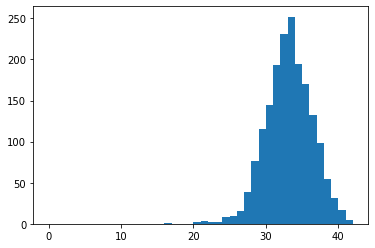

In [6]:
plt.hist(counts, bins=max(counts), range=(0, max(counts)));

In [7]:
MAX_LEN = 45 if DATASET == "MINI-DIGITS" else 300

In [8]:
def to_padded(x_pc, counts):
    padded = np.zeros((len(counts), MAX_LEN, 3), dtype=np.float32)
    start = 0
    for i, count in enumerate(counts):
        stop = start + np.clip(count, 0, MAX_LEN)
        padded[i, :np.clip(count, 0, MAX_LEN)] = x_pc[start : stop]
        start = start + count
    return padded

In [9]:
XMAX = x_train.shape[1]
YMAX = x_train.shape[2]
ZMAX = x_train.max()

In [10]:
def transformed(x_pc):
    "should be called on unpadded inputs"
    x = np.array(x_pc, dtype=np.float32)
    x[..., 0] /= XMAX
    x[..., 1] /= YMAX
    x[..., 2] /= ZMAX
    return x

In [11]:
def inv_transformed(x_pc):
    x = np.array(x_pc, dtype=np.float32)
    x[..., 0] *= XMAX
    x[..., 1] *= YMAX
    x[..., 2] *= ZMAX
    return x

In [12]:
x_train_padded = to_padded(transformed(x_pc), counts)

In [13]:
x_train_padded.shape

(1797, 45, 3)

In [14]:
def to_img(padded):
    "only for a single image, to plot a pointcloud again as an image"
    img = np.zeros((XMAX, YMAX))
    for x, y, z in padded[padded[..., 2] != 0]:
        x = np.clip(x, 0, XMAX - 1)
        y = np.clip(y, 0, YMAX - 1)
        x, y = int(x), int(y)
        img[y, x] = z
    return img

In [15]:
# test roundtrip
plt.subplot(1, 2, 1)
plt.imshow(to_img(to_padded(x_pc[:counts[0]], counts[:1])[0]))
plt.title("original")
plt.subplot(1, 2, 2)
plt.title("transformed and back")
plt.imshow(to_img(inv_transformed(to_padded(transformed(x_pc), counts))[0]))

# Define layers and model

In [16]:
class Sampling(layers.Layer):
    """
    Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    
    mostly copied from https://keras.io/examples/generative/vae/
    """

    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [17]:
class MaskFromPadded(tf.keras.layers.Layer):
    """
    This creates a mask from the padded inputs that can be multiplied to any per-point output
    to produce an output where the padded values are zeroed out
    """
    
    def call(self, inputs):
        return tf.expand_dims(tf.cast(tf.reduce_all(inputs != 0, axis=-1), tf.float32), axis=-1)

In [18]:
class GlobalAveragePoolingPadded(tf.keras.layers.Layer):
    """
    Samme as tf.keras.layers.GlobalAveragePooling1D,
    but applies the mask before to ensure to sum only over non-padded inputs.
    """
    
    def call(self, inputs):
        unpadded, mask = inputs
        return tf.reduce_mean(mask * unpadded, axis=-2)

In [19]:
def create_encoder(shape, latent_dim, n_layers=3, units=100):
    inp = layers.Input(shape=shape)
    h_point = inp
    mask = MaskFromPadded()(inp)

    def repeat(h):
        return tf.repeat(tf.expand_dims(h, axis=1), inp.shape[1], axis=1)

    for i in range(n_layers):
        # per-point permutation equivariant transformation
        h_point = layers.Dense(units, activation="relu")(h_point)
        # permutation invariant aggregation
        h_global = GlobalAveragePoolingPadded()([h_point, mask])
        # concatenate repeated global info to per-point info
        h_point = layers.Concatenate()(
            [
                h_point,
                repeat(h_global),
            ]
        )
        # apply mask
        h_point = h_point * mask
    out = layers.Dense(latent_dim, activation="relu")(h_global)

    z_mean = layers.Dense(latent_dim, name="z_mean")(out)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(out)

    z = Sampling()([repeat(z_mean), repeat(z_log_var)])
    
    z_mean = z_mean
    z_log_var = z_log_var
    z = z * mask

    return tf.keras.Model(inputs=[inp], outputs=[z_mean, z_log_var, z])

In [20]:
encoder = create_encoder(shape=(MAX_LEN, 3), latent_dim=32)

2022-07-19 16:37:13.815342: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-19 16:37:13.816229: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [21]:
tf.keras.utils.plot_model(encoder, show_shapes=True)

In [22]:
def create_decoder(shape, latent_dim, units=100, n_layers=3):
    "Essentially the same architecture as the encoder, but outputs the same shape as the original input"

    inp = layers.Input(shape=(shape[0], latent_dim,))
    h_points = inp
    mask = MaskFromPadded()(inp)
    for i in range(n_layers):
        h_points = layers.Dense(units, activation="relu")(h_points)
        h_global = GlobalAveragePoolingPadded()([h_points, mask])
        h_global = tf.repeat(tf.expand_dims(h_global, axis=1), inp.shape[1], axis=1)
        h_points = layers.Concatenate()(
            [
                h_points,
                h_global,
            ]
        )
        h_points = h_points * mask
    out = layers.Dense(shape[1])(h_points)
    out = out * mask
    return tf.keras.Model(inputs=[inp], outputs=[out])

In [23]:
decoder = create_decoder(shape=(MAX_LEN, 3), latent_dim=32)

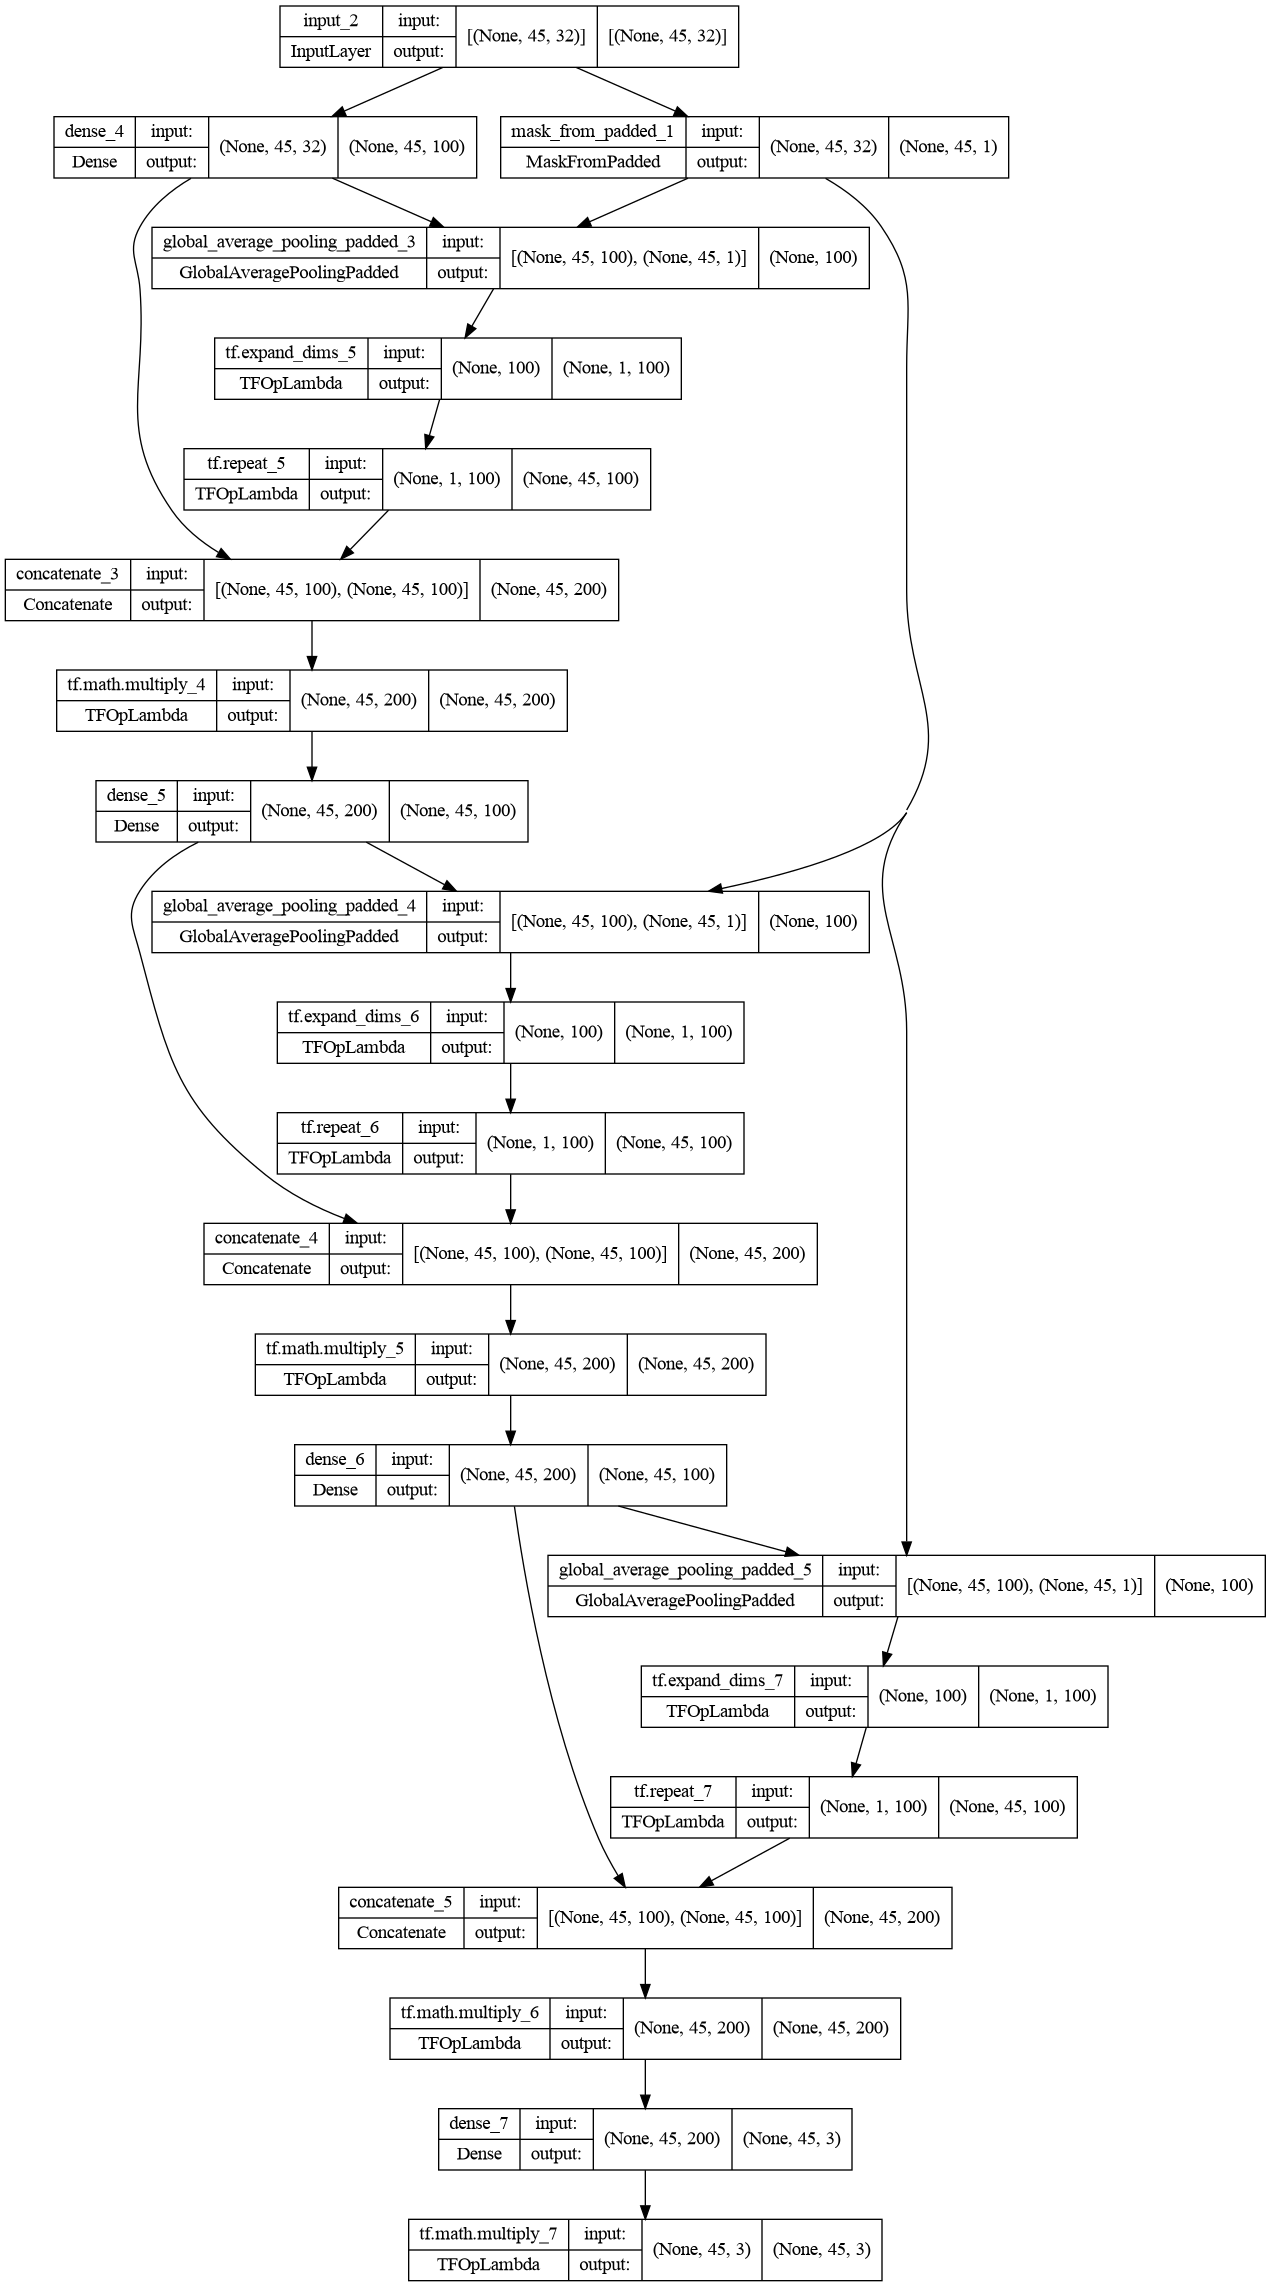

In [24]:
tf.keras.utils.plot_model(decoder, show_shapes=True)

In [25]:
def chamfer_distance(x1, x2):
    x1 = tf.expand_dims(x1, axis=-2)
    x2 = tf.expand_dims(x2, axis=-3)
    sq_dist = tf.reduce_sum((x1 - x2) ** 2, axis=-1)
    return (
        tf.reduce_min(sq_dist, axis=-1)
        + tf.reduce_min(sq_dist, axis=-2)
    )

In [26]:
class VAE(keras.Model):
    "mostly copied from https://keras.io/examples/generative/vae/"

    def __init__(self, encoder, decoder, lam=1, **kwargs):
        "lam: parameter to control the relative contribution of the KL loss (compared to the reconstruction loss)"
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.lam = lam
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(chamfer_distance(data, reconstruction), axis=-1)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + self.lam * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


# Run the training

The hyperparameters might need some fine tuning. "Interesting" (but not really good) results are achieved by

For `DATASET = "MNIST"`: `latent_dim=4, batch_size=512, lam=1e-7`

For `DATASET = "MINI-DIGITS"`: `latent_dim=4, batch_size=32, lam=1e-6`

In [54]:
n_layers = 3
decoder = create_decoder(shape=(MAX_LEN, 3), latent_dim=32, units=32, n_layers=n_layers)
encoder = create_encoder(shape=(MAX_LEN, 3), latent_dim=32, units=32, n_layers=n_layers)

vae = VAE(encoder, decoder, lam=1e-1)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(x_train_padded, epochs=200, batch_size=32,
                  callbacks=keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True, verbose=True))

Epoch 1/200
57/57 [==============================] - 4s 31ms/step - loss: 0.1077 - reconstruction_loss: 0.0760 - kl_loss: 0.0068
Epoch 2/200
57/57 [==============================] - 3s 52ms/step - loss: 0.0538 - reconstruction_loss: 0.0525 - kl_loss: 3.2402e-04
Epoch 3/200
57/57 [==============================] - 2s 37ms/step - loss: 0.0502 - reconstruction_loss: 0.0498 - kl_loss: 1.2029e-04
Epoch 4/200
57/57 [==============================] - 3s 56ms/step - loss: 0.0482 - reconstruction_loss: 0.0479 - kl_loss: 1.1300e-04
Epoch 5/200
57/57 [==============================] - 2s 42ms/step - loss: 0.0471 - reconstruction_loss: 0.0468 - kl_loss: 1.2412e-04
Epoch 6/200
57/57 [==============================] - 3s 48ms/step - loss: 0.0459 - reconstruction_loss: 0.0456 - kl_loss: 1.4162e-04
Epoch 7/200
57/57 [==============================] - 3s 49ms/step - loss: 0.0454 - reconstruction_loss: 0.0448 - kl_loss: 1.3263e-04
Epoch 8/200
57/57 [==============================] - 4s 69ms/step - loss:

In [55]:
pd.DataFrame(history.history).plot()
plt.yscale("log")

In [56]:
history

In [57]:
history = pd.DataFrame(history.history)

<AxesSubplot:>

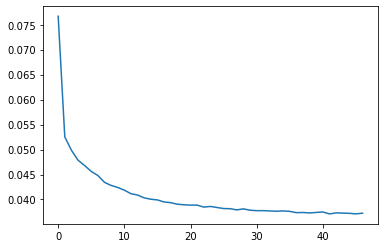

In [58]:
history.loss.plot()

# Inspect latent space for encoded training data

In [59]:
def encode(encoder, x, batch_size=512):
    "somehow `.predict` seems broken? (allocate too much memory)"
    ds = tf.data.Dataset.from_tensor_slices(x)
    latent_real = []
    for batch in tqdm(ds.batch(batch_size)):
        _, _, z = encoder(batch)
        latent_real.append(z.numpy())
    return np.concatenate(latent_real)

In [60]:
latent_real = encode(encoder, x_train_padded)

  0%|          | 0/4 [00:00<?, ?it/s]

In [61]:
latent_real.shape

(1797, 45, 32)

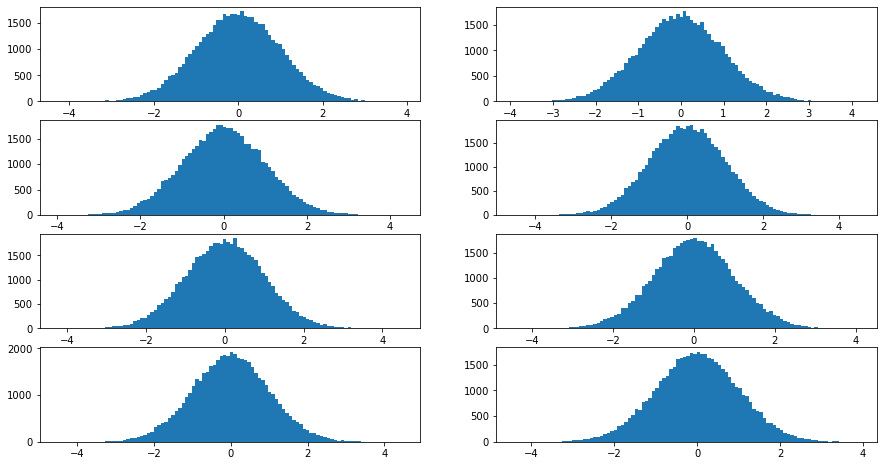

In [62]:
# need to adjust nrows, ncols for different latent_dim
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 8))
for i, ax in zip(range(latent_real.shape[-1]), axs.ravel()):
    _x = latent_real[..., i].ravel()
    _x = _x[_x!=0]
    ax.hist(_x, bins=100)

# Compare input with reconstruction

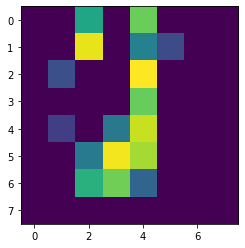

In [63]:
i_img = 16
plt.imshow(to_img(inv_transformed(x_train_padded[i_img:i_img+1])))
plt.figure()
plt.imshow(to_img(inv_transformed(decoder(latent_real[i_img:i_img+1]))))

# Sample latent space and generate new point clouds

In [64]:
def generate_latent_normal(latent_dim, n_points, n_samples):
    """
    sample latent space from random normal distribution (standard way)
    """
    latent_fake = np.random.normal(size=n_samples * MAX_LEN * latent_dim).reshape(-1, MAX_LEN, latent_dim)
    latent_fake[:, n_points:] = 0
    return latent_fake

In [65]:
def generate_latent_from_data(latent_real, n_points, n_samples):
    """
    sample latent space by using the distribution of encoded training data
    (independently for each dimension)
    
    may work better if encoded latent space does not look gaussian
    ... but of course if that's the case then there are likely also correlations
    ... so it will not nescessarily help much
    
    (still, people had success with this, e.g. https://arxiv.org/abs/2005.05334)
    """
    latent_dim = latent_real.shape[-1]
    latent_fake = []
    for i in range(latent_dim):
        real_nonzero = latent_real[..., i].ravel()
        real_nonzero = real_nonzero[real_nonzero != 0]
        latent_fake.append(np.random.choice(real_nonzero, MAX_LEN * n_samples))
    latent_fake = np.stack(latent_fake, axis=-1).reshape(-1, MAX_LEN, latent_dim)
    latent_fake[:, n_points:] = 0
    return latent_fake

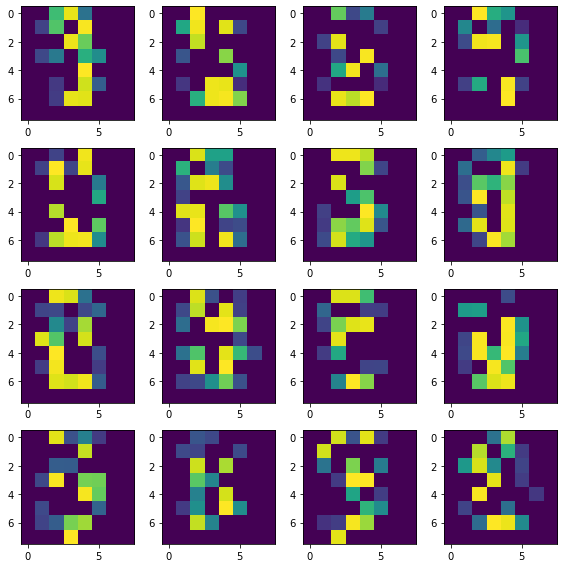

In [66]:
n_points = np.random.choice(counts, 1)[0]
n_samples = 16
#latent_fake = generate_latent_normal(latent_real.shape[-1], 120, 16)
latent_fake = generate_latent_from_data(latent_real, n_points, n_samples)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(to_img(inv_transformed(decoder(latent_fake[i:i+1]))))
fig.tight_layout()